In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_csv(r"C:\Users\hp\Desktop\Instruments_dataset_CA2_10315.csv", encoding='latin1')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Instrument ID      111 non-null    int64  
 1   Model Name/Number  111 non-null    object 
 2   Instrument Type    111 non-null    object 
 3   Brand              111 non-null    object 
 4   Year Manufactured  111 non-null    int64  
 5   Material           111 non-null    object 
 6   Price (INR)        111 non-null    object 
 7   Condition          111 non-null    object 
 8   Country of Origin  111 non-null    object 
 9   Weight (kg)        111 non-null    float64
 10  String Count       74 non-null     float64
 11  Reviews            111 non-null    object 
 12  Electrical or Not  111 non-null    object 
 13  Units Sold         111 non-null    int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 12.3+ KB


In [40]:
df.head()

,Instrument ID,Model Name/Number,Instrument Type,Brand,Year Manufactured,Material,Price (INR),Condition,Country of Origin,Weight (kg),String Count,Reviews,Electrical or Not,Units Sold
0,1001,Stratocaster 2023,Electric Guitar,Fender,2023,Alder Wood,"98,999",New,USA,3.5,6.0,4.8/5,Yes,320
1,1002,D-28,Acoustic Guitar,Martin,2021,Rosewood,"2,22,000",New,USA,2.2,6.0,4.9/5,No,80
2,1003,YDP-144 Arius,Digital Piano,Yamaha,2022,Synthetic Ivory,"90,000",New,Japan,38.0,NaN,4.7/5,Yes,450
3,1004,Sitar Classic,Sitar,Radha Krishna,2020,Teak Wood,"35,000",New,India,5.5,7.0,4.6/5,No,200
4,1005,TR-909,Drum Machine,Roland,2017,Plastic,"2,08,000",Used,Japan,6.5,NaN,4.5/5,Yes,70


In [41]:
df['Price (INR)'] = df['Price (INR)'].str.replace(',', '').astype(int)
#create df_filtered var which excludes the grand piano for being an outlier
df_filtered = df[df['Instrument Type'] != 'Grand Piano']

Describe the data

In [42]:
summary = df_filtered[['Brand', 'Units Sold', 'Weight (kg)']].describe()
print(summary)

       Units Sold  Weight (kg)
count  110.000000   110.000000
mean    89.881818     5.338000
std     66.380711     6.523003
min     15.000000     0.130000
25%     50.000000     2.300000
50%     75.000000     3.550000
75%    100.000000     4.500000
max    450.000000    38.000000


Check for missing values

In [47]:
missing_values = df_filtered.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Instrument ID         0
Model Name/Number     0
Instrument Type       0
Brand                 0
Year Manufactured     0
Material              0
Price (INR)           0
Condition             0
Country of Origin     0
Weight (kg)           0
String Count         36
Reviews               0
Electrical or Not     0
Units Sold            0
dtype: int64


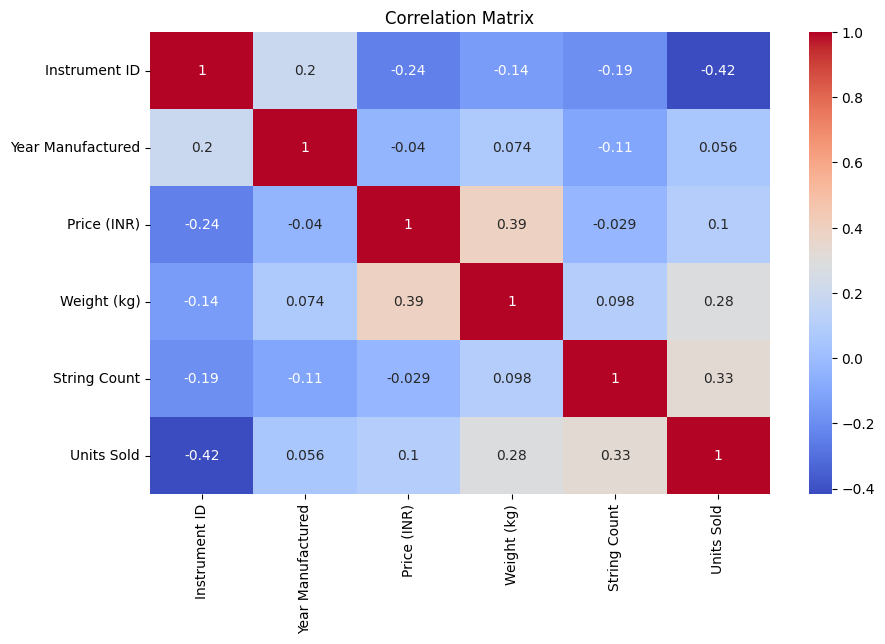

In [49]:
# Get only numerical columns
numerical_df = df_filtered.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


It can be deducted that:
Weight and String Count have a moderate positive impact on Units Sold.
Price and Year Manufactured show weaker correlations with sales, implying other factors like features (e.g., strings, weight) may play a larger role in determining sales figures.

In [50]:
#REMOVING OUTLIERS
# Removing outliers for Year Manufactured
df = df[(df['Year Manufactured'] >= df['Year Manufactured'].mean() - 3 * df['Year Manufactured'].std()) &
        (df['Year Manufactured'] <= df['Year Manufactured'].mean() + 3 * df['Year Manufactured'].std())]

# Removing outliers for Weight
Q1 = df['Weight (kg)'].quantile(0.25)
Q3 = df['Weight (kg)'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Weight (kg)'] >= Q1 - 1.5 * IQR) & (df['Weight (kg)'] <= Q3 + 1.5 * IQR)]

# Removing outliers for Units Sold
Q1_units = df['Units Sold'].quantile(0.25)
Q3_units = df['Units Sold'].quantile(0.75)
IQR_units = Q3_units - Q1_units
df = df[(df['Units Sold'] >= Q1_units - 1.5 * IQR_units) & (df['Units Sold'] <= Q3_units + 1.5 * IQR_units)]


In [51]:
#MODEL TRAINING (LINEAR REGRESSION MDOEL)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Identify categorical and numerical features
categorical_features = ['Brand', 'Material', 'Country of Origin']  # Update with your categorical features
numerical_features = ['Year Manufactured', 'Weight (kg)', 'Units Sold']  # Your numerical features

# Separate features and target variable
X = df_filtered.drop('Price (INR)', axis=1)  # Features
y = df_filtered['Price (INR)']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a preprocessor with OneHotEncoder for categorical features
# the preprocessor is a crucial part of the data pipeline that handles the preprocessing of 
# different types of data in your dataset (numerical and categorical) before training the machine learning model. 
# This ensures that all features are in a suitable format for the model to learn from.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # Leave numerical features as is
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical features
    ])

# pipeline with preprocessor and model
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', LinearRegression())])

# Fit the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Check predictions
print(y_pred)


[117590.81318057  48427.03217164  58131.55617262 217662.73355713
  60028.64536589 -61594.4151693   14079.32551107 233640.67299141
 195306.96576864  14479.1513482   57999.55954969  60641.33547256
 143302.17152223 122389.63004029  13387.62640917 155811.68507018
  40973.07946924  61170.62619814  13909.2746176   30739.48630827
 128089.34743929  78301.21771801]


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# evaluate the accuracy and effectiveness of THE linear regression model
mae = mean_absolute_error(y_test, y_pred) #the average absolute difference between the predicted values (y_pred) and the actual values (y_test)
mse = mean_squared_error(y_test, y_pred) #
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 44777.857616822825
Mean Squared Error: 3750491763.0198154
R-squared: -0.3470561782731192


Lower Values indicate better performance.
Here, Metrics show high level of inaccuracy model because of small dataset but the implementation is right.
An R² below 0 suggests that the linear regression model is a poor fit for your data and doesn't explain the variance in the target variable well.

In [54]:
# Example 
new_data = {
    'Brand': ['Yamaha'],
    'Material': ['Wood'],
    'Country of Origin': ['China'],
    'Year Manufactured': [2024],
    'Weight (kg)': [1.5],
    'Units Sold': [20]
}

# Converting example data to DataFrame
new_df = pd.DataFrame(new_data)

# Predict the price for the new data
predicted_price = model.predict(new_df)
print(f"Predicted Price: {predicted_price[0]}")


Predicted Price: 76573.86940165237


# Questions
1. Average Price by Instrument Type

**Question:** What is the average price of each type of instrument?

**Analysis:** Compute the average price for each instrument type (e.g., Electric Guitar, Acoustic Guitar, Digital Piano) and visualize the results with a bar chart.

There are 30 unique instrument types after removing "Grand Piano".
Average price for each instrument type:
Instrument Type
Dholak                7500.000000
Microphone            8000.000000
Flute                 8175.000000
Percussion           11250.000000
Ukulele              12000.000000
Tabla                12333.333333
Amplifier            15000.000000
Tanpura              15000.000000
Keyboard             17666.666667
Pakhawaj             18000.000000
Mridangam            20000.000000
Harmonium            22500.000000
Sitar                32500.000000
DJ Controller        35000.000000
Classical Guitar     36000.000000
Bouzouki             40000.000000
Veena                45000.000000
Sarod                60000.000000
Electronic Drum      60000.000000
Digital Piano        69166.666667
Acoustic Guitar      69411.764706
Electric Guitar      84296.259259
Kora                 85000.000000
Bass Guitar          92833.333333
Handpan             100000.000000
Synthesizer         108333.

C:\Users\hp\AppData\Local\Temp\ipykernel_2428\2455564101.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_instrument.index, y=avg_price_by_instrument.values, palette='viridis')


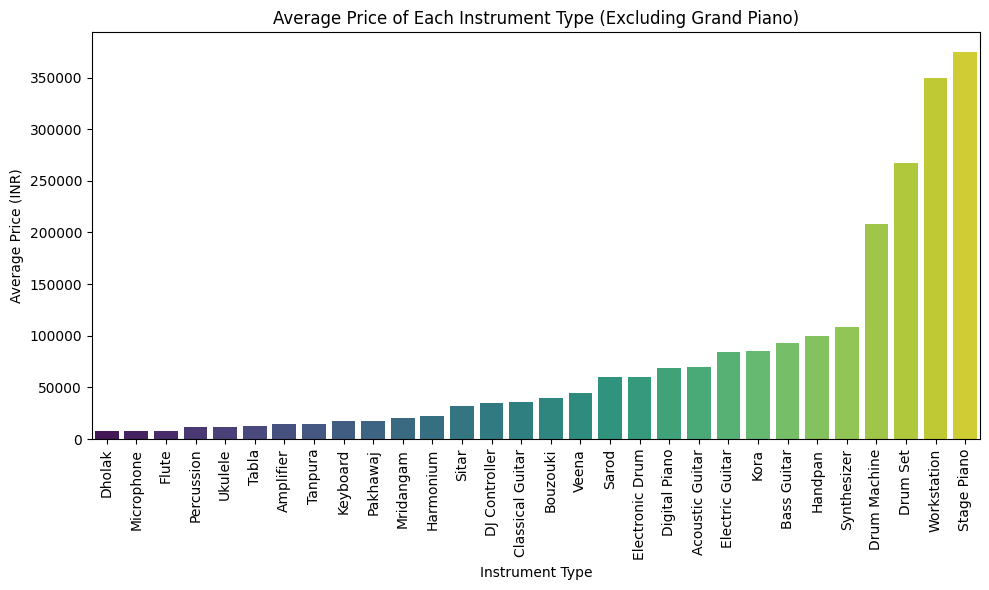

In [55]:
num_instrument_types = df_filtered['Instrument Type'].nunique()
print(f'There are {num_instrument_types} unique instrument types after removing "Grand Piano".')

avg_price_by_instrument = df_filtered.groupby('Instrument Type')['Price (INR)'].mean().sort_values()
print('Average price for each instrument type:')
print(avg_price_by_instrument)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_price_by_instrument.index, y=avg_price_by_instrument.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Price of Each Instrument Type (Excluding Grand Piano)')
plt.xlabel('Instrument Type')
plt.ylabel('Average Price (INR)')
plt.tight_layout()
plt.show()


2. Price Distribution by Brand

**Question:** How does the price of instruments vary by brand?

**Analysis:** Create a box plot to show the distribution of prices for different brands.


Using a Bar Plot with error bars insstead of box plots since thats more suitable in this case.
the error bars represent the variability or uncertainty in the average price

most common instrument type :Electric Guitar
Brands for the most common instrument type 'Electric Guitar':
['Fender' 'Gibson' 'Ibanez' 'Epiphone' 'PRS' 'Ernie Ball' 'Vintage' 'ESP'
 'B.C. Rich' 'Yamaha' 'Gretsch' 'Chapman' 'Schecter' 'Dean' 'Squier'
 'Jackson']
         Brand      mean           std
13      Squier   20000.0           NaN
4     Epiphone   30000.0           NaN
10     Jackson   30000.0           NaN
14     Vintage   40000.0           NaN
12    Schecter   45000.0           NaN
9       Ibanez   46400.0  26548.069610
2         Dean   50000.0           NaN
8      Gretsch   52500.0   3535.533906
1      Chapman   65000.0           NaN
0    B.C. Rich   75000.0           NaN
15      Yamaha   85000.0           NaN
3          ESP   85000.0           NaN
11         PRS   87500.0   3535.533906
6       Fender  139499.5  57276.356383
5   Ernie Ball  150000.0           NaN
7       Gibson  162000.0  55856.960175


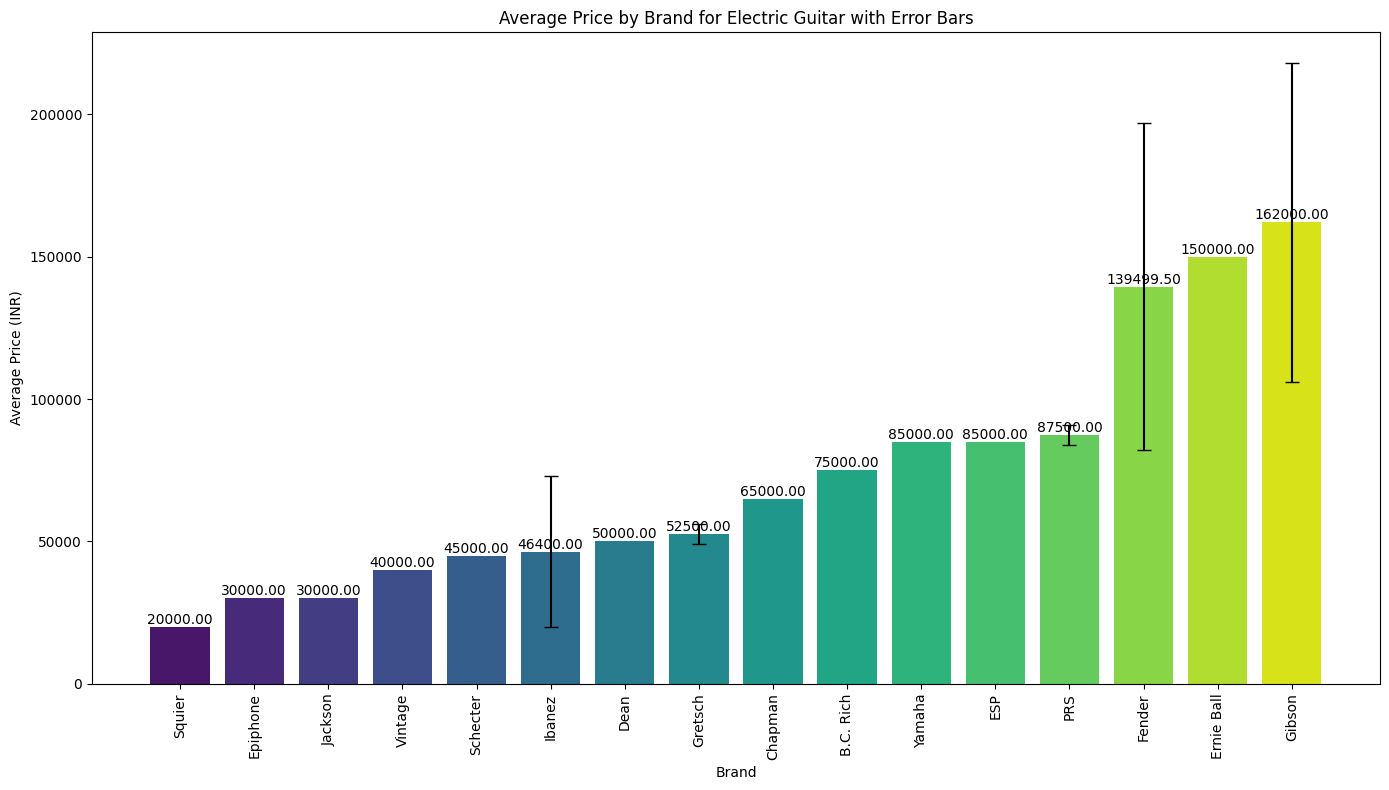

In [59]:
most_common_type = df_filtered['Instrument Type'].mode()[0]
print(f"most common instrument type :{most_common_type}")

filtered_by_type = df_filtered[df_filtered['Instrument Type'] == most_common_type]

brands = filtered_by_type['Brand'].unique()
print(f"Brands for the most common instrument type '{most_common_type}':")
print(brands)

brand_stats = filtered_by_type.groupby('Brand')['Price (INR)'].agg(['mean', 'std']).reset_index()
brand_stats = brand_stats.sort_values(by='mean', ascending=True)
print (brand_stats)

plt.figure(figsize=(14,8))
bars = plt.bar(brand_stats['Brand'], brand_stats['mean'], color=sns.color_palette('viridis', len(brand_stats)), yerr=brand_stats['std'], capsize=5)
plt.xticks(rotation=90)
plt.title(f'Average Price by Brand for {most_common_type} with Error Bars')
plt.xlabel('Brand')
plt.ylabel('Average Price (INR)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout() 
plt.show()


Condition vs. Price

**Question**: How does the condition of the instrument (New vs. Used) affect its price?

**Analysis**: Compare the average price of new versus used instruments using a bar chart or box plot.

  Condition          mean   median           std
0       New  70142.708738  45000.0  80062.722613
1      Used  99714.285714  85000.0  80945.896099


<Figure size 1200x600 with 0 Axes>

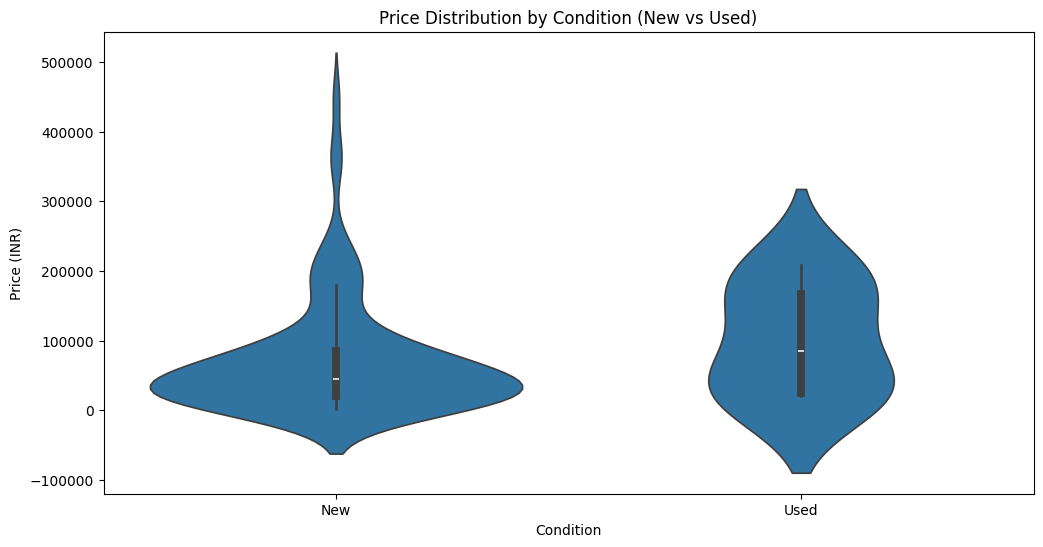

T-statistic: -0.9359465310451, P-value: 0.38123670771579177
Fail to reject the null hypothesis: there is no significant difference in the average prices of new and used instruments.


In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load your dataset
# df_filtered = pd.read_csv('your_data.csv')  # Example of loading data

# Example of filtering conditions, if not already done
# Ensure 'Condition' column has 'New' and 'Used' entries

# Descriptive Statistics
condition_stats = df_filtered.groupby('Condition')['Price (INR)'].agg(['mean', 'median', 'std']).reset_index()
print(condition_stats)

# Visualization
plt.figure(figsize=(12, 6))

# Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Condition', y='Price (INR)', data=df_filtered)
plt.title('Price Distribution by Condition (New vs Used)')
plt.ylabel('Price (INR)')
plt.xlabel('Condition')
plt.show()

# Statistical Test (Independent t-test)
new_prices = df_filtered[df_filtered['Condition'] == 'New']['Price (INR)']
used_prices = df_filtered[df_filtered['Condition'] == 'Used']['Price (INR)']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(new_prices, used_prices, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of P-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in prices based on condition.")
else:
    print("Fail to reject the null hypothesis: there is no significant difference in the average prices of new and used instruments.")

4. Average Rating by Instrument Type

**Question**: What is the average rating for each type of instrument?

**Analysis**: Compute the average rating for each instrument type and visualize it using a bar chart.

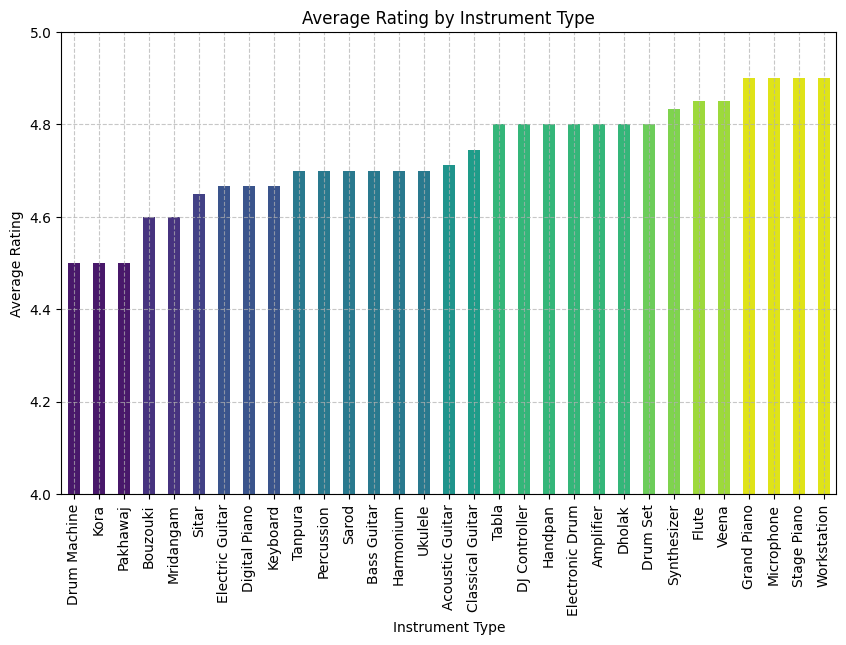

In [8]:
df['Reviews'] = df['Reviews'].str.split('/').str[0].astype(float)

avg_rating_by_type = df.groupby('Instrument Type')['Reviews'].mean().sort_values()

plt.figure(figsize=(10,6))
colors = sns.color_palette('viridis', as_cmap=True)  # Create a colormap
bars = avg_rating_by_type.plot(kind='bar', color=colors(avg_rating_by_type.rank(pct=True)), figsize=(10,6))

plt.title('Average Rating by Instrument Type')
plt.ylabel('Average Rating')
plt.xlabel('Instrument Type')
plt.ylim(4, 5)  # Set y-axis limit for better visualization

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

5. Weight Distribution by Instrument Type

**Question**: What is the distribution of weights for each instrument type?

**Analysis**: Use a box plot or histogram to show the weight distribution for each instrument type.

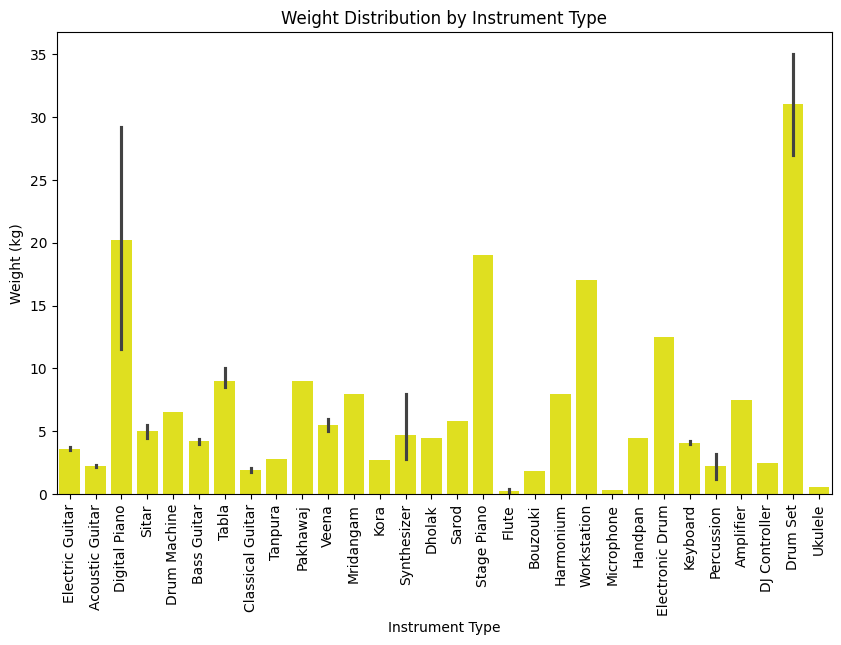

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x='Instrument Type', y='Weight (kg)', data=df_filtered, color= "yellow")
plt.title('Weight Distribution by Instrument Type')
plt.xticks(rotation=90)
plt.show()


6. Price vs. Weight

**Question**: Is there a correlation between the weight of the instrument and its price?

**Analysis**: Create a scatter plot to explore the relationship between weight and price, and calculate the correlation coefficient.

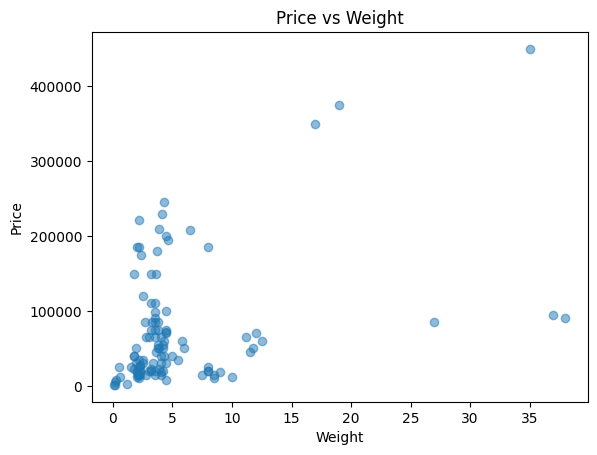

0.39243553322042235
Correlation between Price and Weight: 0.39243553322042235


In [10]:
plt.scatter(df_filtered['Weight (kg)'], df_filtered['Price (INR)'], alpha=0.5)
plt.title('Price vs Weight')
plt.xlabel('Weight')
plt.ylabel('Price')
plt.show()

# Correlation coefficient
correlation = df_filtered['Weight (kg)'].corr(df_filtered['Price (INR)'])
print(correlation)
print(f'Correlation between Price and Weight: {correlation}')


The data points in above plot show upward trend, though it is weak.
This means that there is a slight tendency for instruments with a higher weight to also have a higher price. However, the  correlation coefficient is positive bubt relatively low, indicating that the weight is not a very strong predictor of price. There are likely other factors that play a more significant role in determining the price of an instrument.
**Hence a weak positive correlation between the weight of the instrument and its price.**

7. Electrical vs. Non-Electrical Instruments

**Question**: How do prices and ratings compare between electrical and non-electrical instruments?

**Analysis**: Compare the average price and average rating of electrical versus non-electrical instruments using bar charts or box plots.

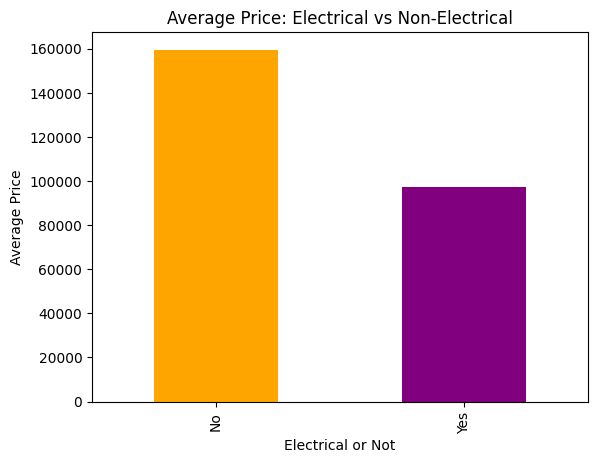

------------------------------------------------------------------------


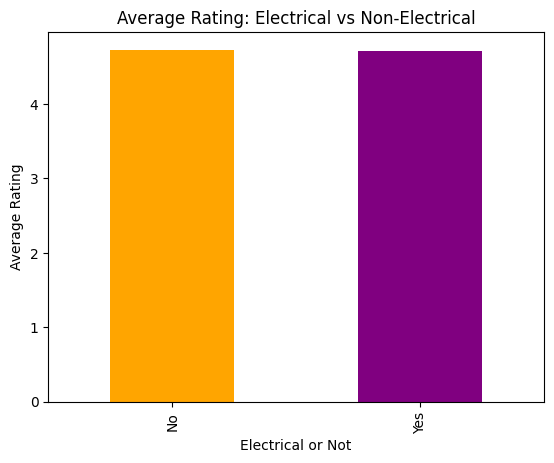

In [11]:
avg_price_electrical = df.groupby('Electrical or Not')['Price (INR)'].mean()
avg_rating_electrical = df.groupby('Electrical or Not')['Reviews'].mean()

avg_price_electrical.plot(kind='bar', title='Average Price: Electrical vs Non-Electrical', color=['orange', 'purple'])
plt.ylabel('Average Price')
plt.show()
print("------------------------------------------------------------------------")
avg_rating_electrical.plot(kind='bar', title='Average Rating: Electrical vs Non-Electrical', color=['orange', 'purple'])
plt.ylabel('Average Rating')
plt.show()


8. Country of Origin Analysis

**Question**: How does the average price of instruments vary by country of origin?

**Analysis**: Calculate the average price for instruments from each country and visualize the results with a bar chart.

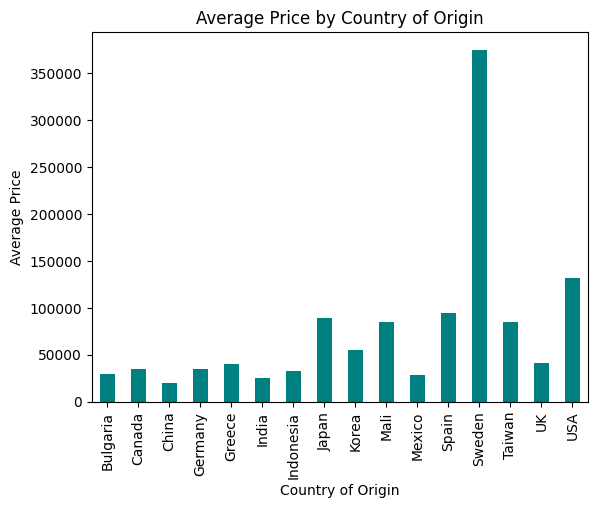

In [12]:
avg_price_by_country = df_filtered.groupby('Country of Origin')['Price (INR)'].mean()

avg_price_by_country.plot(kind='bar', color='teal')
plt.title('Average Price by Country of Origin')
plt.ylabel('Average Price')
plt.xlabel('Country of Origin')
plt.show()


9. Instrument Type vs. String Count

**Question**: What is the average string count for each type of instrument (where applicable)?

**Analysis**: Calculate the average string count for each instrument type and visualize it with a bar chart. Note that not all instruments have string counts.

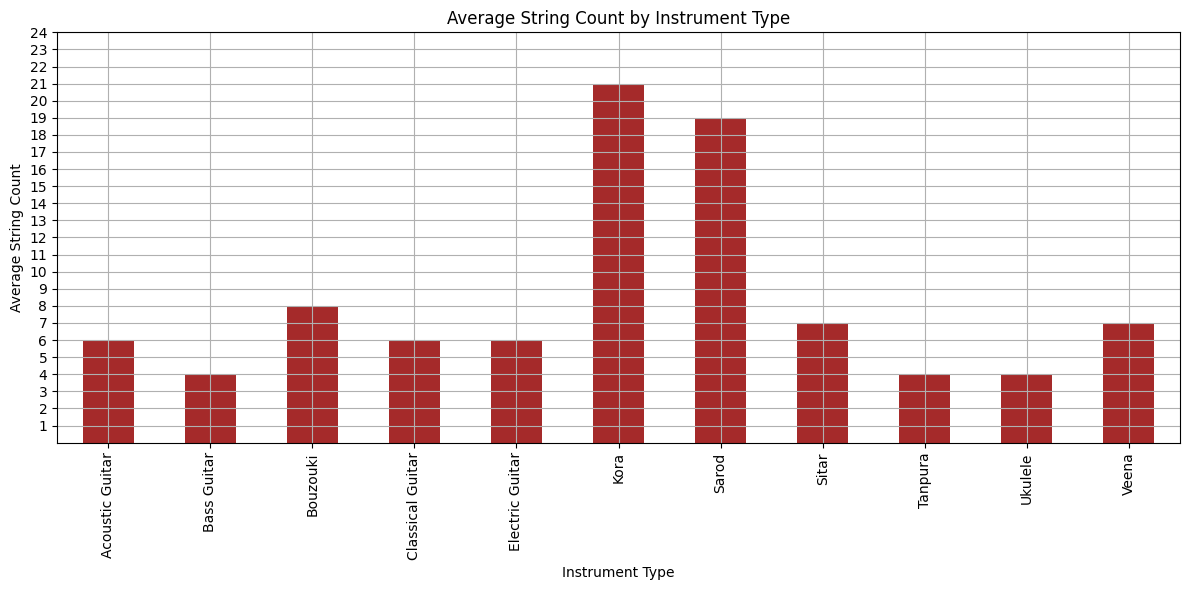

In [13]:
# Filter out rows with 'N/A' in 'String Count' and convert 'String Count' to numeric
df_filtered = df[df['String Count'] != 'N/A']
df_filtered['String Count'] = pd.to_numeric(df_filtered['String Count'], errors='coerce')

df_filtered = df_filtered.dropna(subset=['String Count'])

avg_string_count = df_filtered.groupby('Instrument Type')['String Count'].mean()

plt.figure(figsize=(12, 6))
avg_string_count.astype(int).plot(kind='bar', color='brown')
plt.title('Average String Count by Instrument Type')
plt.ylabel('Average String Count')
plt.xlabel('Instrument Type')
plt.grid(True)

plt.yticks(range(1,25))

plt.tight_layout()
plt.show()

10. Material Analysis

**Question**: What materials are commonly used for different types of instruments, and how does the material affect the price?

**Analysis**: Create a bar chart to show the frequency of materials used for each instrument type, and analyze the average price for each material.

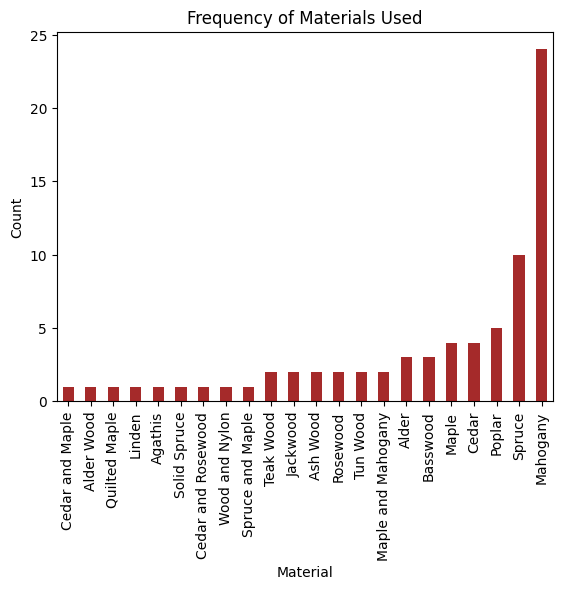

--------------------------------------------------------------------------


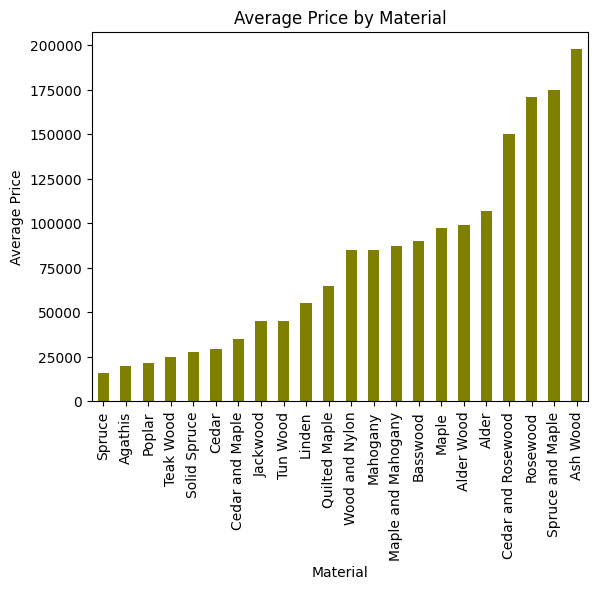

In [14]:
material_count = df_filtered['Material'].value_counts().sort_values()

material_count.plot(kind='bar', color='brown')
plt.title('Frequency of Materials Used')
plt.ylabel('Count')
plt.xlabel('Material')
plt.show()

print("--------------------------------------------------------------------------")
avg_price_by_material = df_filtered.groupby('Material')['Price (INR)'].mean().sort_values()

avg_price_by_material.plot(kind='bar', color='olive')
plt.title('Average Price by Material')
plt.ylabel('Average Price')
plt.xlabel('Material')
plt.show()


11. Year Manufactured vs. Price

**Question**: Is there a trend in price related to the year the instrument was manufactured?

**Analysis**: Create a scatter plot to visualize the relationship between the year of manufacture and price.

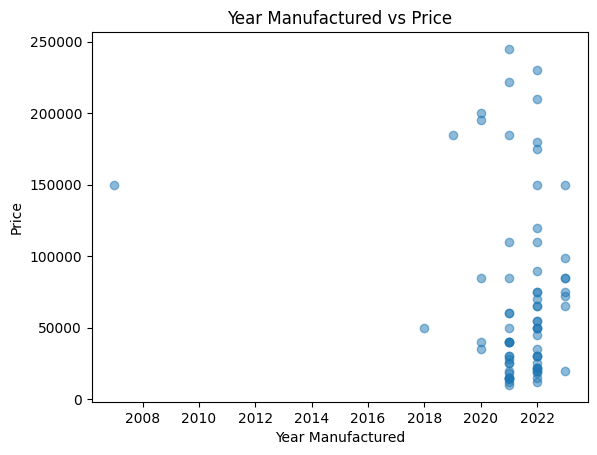

In [15]:
plt.scatter(df_filtered['Year Manufactured'], df_filtered['Price (INR)'], alpha=0.5)
plt.title('Year Manufactured vs Price')
plt.xlabel('Year Manufactured')
plt.ylabel('Price')
plt.show()


12. Average Price by Seller Rating

**Question**: How does the average price vary with seller rating?

**Analysis**: Create a scatter plot to examine the relationship between seller rating and price, and calculate the average price for different rating ranges.

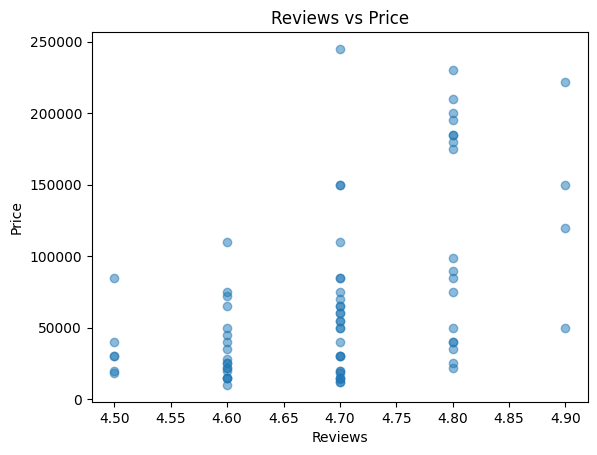

C:\Users\hp\AppData\Local\Temp\ipykernel_51104\1377296569.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_rating = df_filtered.groupby('Seller Rating Range')['Price (INR)'].mean()


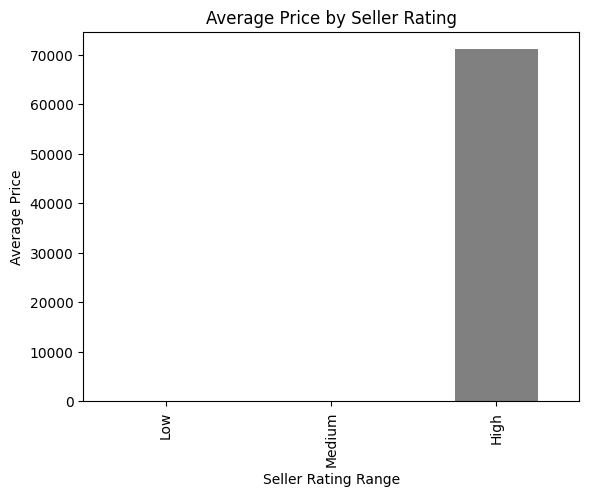

In [16]:
plt.scatter(df_filtered['Reviews'], df_filtered['Price (INR)'], alpha=0.5)
plt.title('Reviews vs Price')
plt.xlabel('Reviews')
plt.ylabel('Price')
plt.show()

df_filtered['Seller Rating Range'] = pd.cut(df_filtered['Reviews'], bins=[0, 2, 4, 5], labels=['Low', 'Medium', 'High'])
avg_price_by_rating = df_filtered.groupby('Seller Rating Range')['Price (INR)'].mean()

avg_price_by_rating.plot(kind='bar', color='gray')
plt.title('Average Price by Seller Rating')
plt.ylabel('Average Price')
plt.xlabel('Seller Rating Range')
plt.show()


13. Price Distribution by Condition and Instrument Type

**Question**: How does the price distribution of instruments vary by condition (New vs. Used) within each instrument type?

**Analysis**: Use a box plot or violin plot to show the price distribution of new and used instruments within each instrument type.

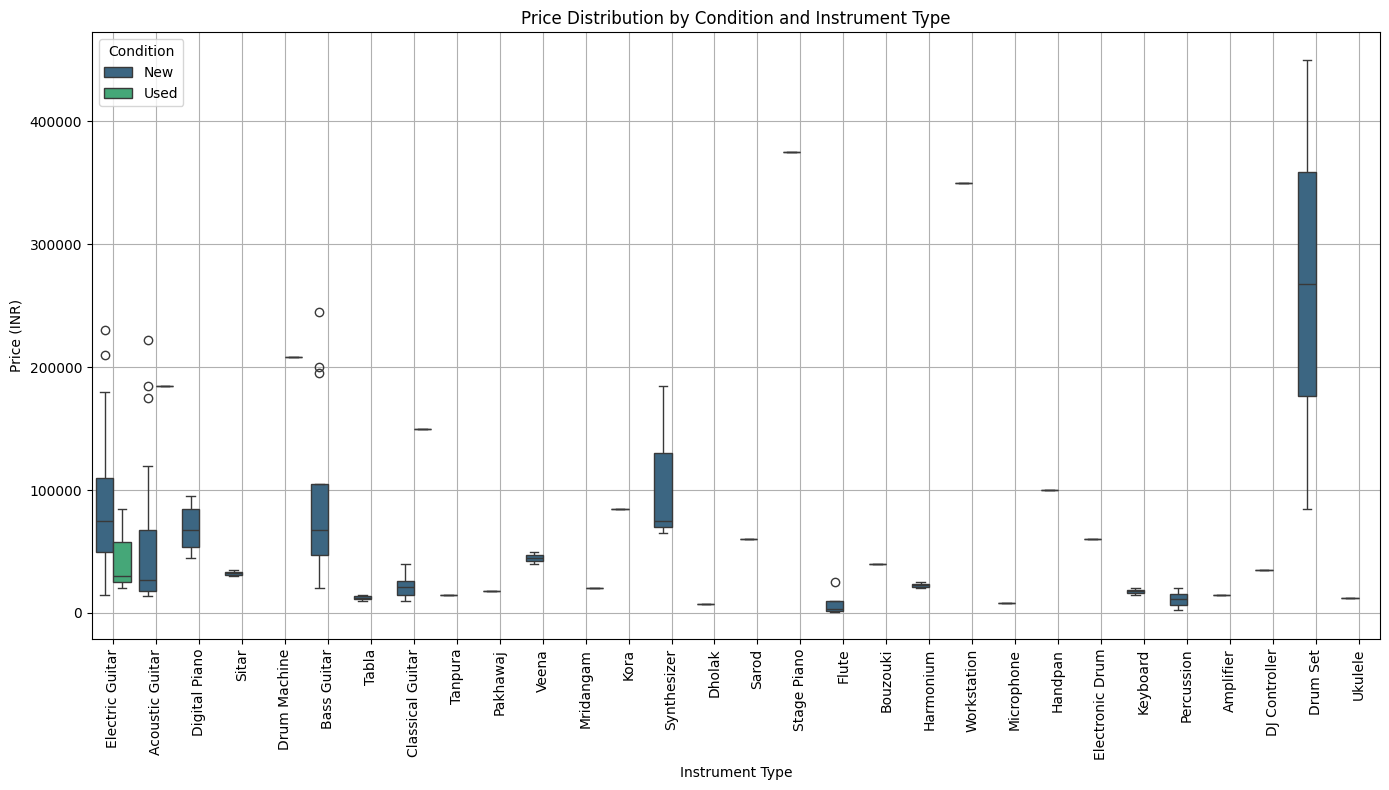

T-test Results for Price Distribution by Condition within Each Instrument Type:
Electric Guitar - T-statistic: 1.8921036517407501, P-value: 0.14065294483057614
Acoustic Guitar - T-statistic: nan, P-value: nan
Classical Guitar - T-statistic: nan, P-value: nan


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [67]:
df_filtered['Price (INR)'] = pd.to_numeric(df_filtered['Price (INR)'], errors='coerce')

df_filtered = df_filtered.dropna(subset=['Price (INR)', 'Condition'])

plt.figure(figsize=(14,8))
sns.boxplot(x='Instrument Type', y='Price (INR)', hue='Condition', data=df_filtered, palette='viridis')
plt.xticks(rotation=90)  # Rotate x labels to ensure visibility
plt.title('Price Distribution by Condition and Instrument Type')
plt.xlabel('Instrument Type')
plt.ylabel('Price (INR)')
plt.grid(True)
plt.tight_layout()
plt.show()
from scipy.stats import ttest_ind
ttest_results = {}
for instrument_type in df_filtered['Instrument Type'].unique():
    new_prices = df_filtered[(df_filtered['Instrument Type'] == instrument_type) & (df_filtered['Condition'] == 'New')]['Price (INR)']
    used_prices = df_filtered[(df_filtered['Instrument Type'] == instrument_type) & (df_filtered['Condition'] == 'Used')]['Price (INR)']
    
    if len(new_prices) > 0 and len(used_prices) > 0:
        t_stat, p_value = ttest_ind(new_prices, used_prices, equal_var=False)  # Use Welch's t-test by setting equal_var=False
        ttest_results[instrument_type] = {'T-statistic': t_stat, 'P-value': p_value}

print("T-test Results for Price Distribution by Condition within Each Instrument Type:")
for instrument_type, result in ttest_results.items():
    print(f"{instrument_type} - T-statistic: {result['T-statistic']}, P-value: {result['P-value']}")


14. Price by Instrument Model

**Question**: What is the price distribution for different models of instruments?

**Analysis**: Use a bar chart to visualize the price for each model.

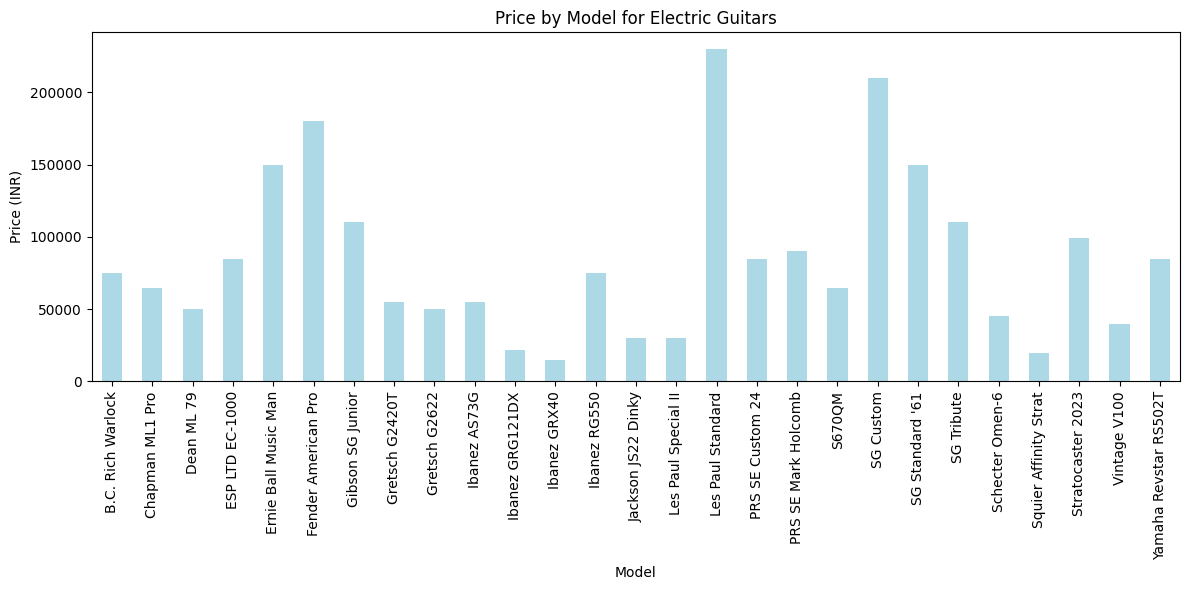

In [18]:
# Bar chart for price distribution by only taking models of "Instrument Type" = "Electric Guitar" as there are large number of models
electric_guitar_models = df[df['Instrument Type'] == 'Electric Guitar']

avg_price_by_model = electric_guitar_models.groupby('Model Name/Number')['Price (INR)'].mean()

# Plotting the results
plt.figure(figsize=(12,6))
avg_price_by_model.plot(kind='bar', color='lightblue')
plt.title('Price by Model for Electric Guitars')
plt.ylabel('Price (INR)')
plt.xlabel('Model')
plt.xticks(rotation=90)  # Rotate x labels to ensure visibility
plt.tight_layout()
plt.show()


15. Material vs. Condition Analysis

**Question**: How does the condition of the instrument (New vs. Used) vary by material?

**Analysis**: Create a stacked bar chart to show the distribution of conditions for different materials.

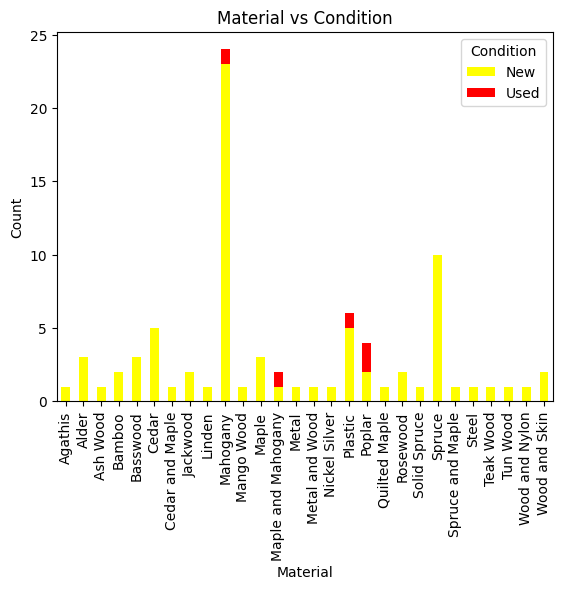

In [68]:
condition_material = pd.crosstab(df['Material'], df['Condition'])

condition_material.plot(kind='bar', stacked=True, color=['yellow', 'red'])
plt.title('Material vs Condition')
plt.ylabel('Count')
plt.xlabel('Material')
plt.show()